Задача:
- Существует датасет с данными о покупках за период с января 2016 года по декабрь 2019. Задача найти пользователей, у которых последняя покупка была наименее давно, которые покупают наиболее часто и суммы покупок которых самые большие. Также необходимо найти группу пользователей, для которых целесообразно подобрать программу лояльности для повышения их среднего чека и как результат повышения сумм их покупок.

Для решения поставленной задачи я применю RFM-анализ, который позволит сегментировать пользователей по времени, прошедшем с последней покупки, частосте и общей сумме покупок.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_excel('Sample_-_Superstore.xls')

In [3]:
df.head(2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country/Region,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2018-152156,2018-11-08,2018-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2018-152156,2018-11-08,2018-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820


Определяем временные рамки набора данных:

In [5]:
df['Order Date'].min()

Timestamp('2016-01-03 00:00:00')

In [7]:
df['Order Date'].max()

Timestamp('2019-12-30 00:00:00')

Отбросим лишние данные

In [8]:
df = df[['Order ID','Customer ID','Order Date', 'Sales', 'Quantity']]

In [9]:
new_col = [x.lower().replace(' ', '_') for x in df.columns.tolist()]

In [10]:
df.set_axis(new_col, axis=1, inplace=True)

In [11]:
df.dtypes

order_id               object
customer_id            object
order_date     datetime64[ns]
sales                 float64
quantity                int64
dtype: object

In [12]:
df['margin'] = df.sales * df.quantity

<ipython-input-12-5f46e0542a7f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['margin'] = df.sales * df.quantity


In [13]:
df.drop(['sales', 'quantity'], axis=1, inplace=True)

c:\users\ohrem\appdata\local\programs\python\python39\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [14]:
df.head()

,order_id,customer_id,order_date,margin
0,CA-2018-152156,CG-12520,2018-11-08,523.9200
1,CA-2018-152156,CG-12520,2018-11-08,2195.8200
2,CA-2018-138688,DV-13045,2018-06-12,29.2400
3,US-2017-108966,SO-20335,2017-10-11,4787.8875
4,US-2017-108966,SO-20335,2017-10-11,44.7360


In [15]:
# определим дату, от которой будем считать давность последних покупок
last_date = df.order_date.max()

Определим для каждого пользователя:
1. Количество дней прошедших с последней покупки
2. Количестов покупок за весь срок
3. Общая сумма покупок

In [16]:
rfm_Table = df.groupby('customer_id').agg({'order_date': lambda x: (last_date - x.max()).days, \
                                'order_id': lambda x: len(x), \
                                'margin' : lambda x: x.sum()})

In [17]:
rfm_Table.rename(columns={'order_date' : 'recency',
                          'order_id': 'frequency',
                          'margin': 'monetary_value'}, inplace=True)

In [18]:
rfm_Table

,recency,frequency,monetary_value
customer_id,,,
AA-10315,184,11,16073.344
AA-10375,19,15,2734.830
AA-10480,259,12,5493.936
AA-10645,55,18,22927.855
AB-10015,415,6,1984.480
...,...,...,...
XP-21865,43,28,8676.214
YC-21895,4,8,27208.926
YS-21880,9,12,46478.992


In [19]:
rfmSegmentation = rfm_Table[:]

In [20]:
# определим границы для деления пользователей на группы.
quantiles = rfm_Table.quantile(q=[0.25, 0.5, 0.75])
quantiles

,recency,frequency,monetary_value
0.25,30.0,8.0,4768.010
0.50,75.0,12.0,9974.654
0.75,183.0,16.0,18527.648


Итак, пльзователи будут разделены по 3 признакам на 4 группы:
- recency: 1-я группа от 0 до 30 дней, 2-я от 31 до 75, 3-я от 76 до 183, 4-я от 184 дней.
- frequency: 1-я группа от 16 раз, 2-я от 15 до 12, 3-я от 11 до 8, 4-я менее 8 раз.
- monetary_value: 1-я группа от 18527.65, 2-я от 18527.64 до 9974.65, 3-я от 9974.64 до 4768.01, 4-я менее 4768.

Определим две функции:
1. Будем использовать для разделения пользователей на 4 группы в зависимости от давности последней покупки. Чем меньше дней прошло с последней покупки тем меньше число группы (RClass).
2. Будем использовать для разделения пользователей на группы в зависимости от частоты и суммы покупок. Чем меньше количество и сумма покупок тем меньше число группы (FMSlass).

In [21]:
def RClass(value,parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 3
    else:
        return 4


def FMClass(value, parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.50]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 2
    else:
        return 1


In [22]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles))

rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles))

rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quantiles))

rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str) \
                            + rfmSegmentation.F_Quartile.map(str) \
                            + rfmSegmentation.M_Quartile.map(str)

<ipython-input-22-aa72363cc0e7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles))
<ipython-input-22-aa72363cc0e7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles))
<ipython-input-22-aa72363cc0e7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [23]:
rfmSegmentation.reset_index(inplace=True)

In [24]:
rfmSegmentation.RFMClass = rfmSegmentation.RFMClass.astype(int)

c:\users\ohrem\appdata\local\programs\python\python39\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Перед нами посталено по-сути две задачи:
1. Найти пользователей, у которых последняя покупка была наименее давно, которые покупают наиболее часто и суммы покупок которых самые большие.
2. Найти группу пользователей, для которых целесообразно подобрать программу лояльности для повышения их среднего чека и как результат повышения сумм их покупок.

Для первой задачи нам необходима группа пользователей, у которой значене RFMClass состаляет 111

In [25]:
rfmSegmentation[rfmSegmentation.RFMClass == 111].customer_id.count()

27

In [26]:
top_users = rfmSegmentation[rfmSegmentation.RFMClass == 111].customer_id.tolist()

In [27]:
top_users

['AI-10855',
 'BB-11545',
 'BH-11710',
 'BP-11185',
 'CC-12220',
 'DK-13225',
 'DR-12880',
 'EP-13915',
 'ES-14080',
 'HM-14860',
 'JG-15160',
 'JL-15835',
 'KH-16510',
 'KL-16555',
 'LC-16885',
 'MH-18115',
 'MP-18175',
 'ND-18370',
 'NP-18325',
 'PK-19075',
 'PO-18850',
 'RB-19465',
 'SC-20380',
 'SE-20110',
 'SM-20950',
 'VW-21775',
 'WB-21850']

Для второй задачи нам можно подобрать разные группы пользователей, но я считаю, что наиболее перспективной группой в контексте поставленной задачи может быть группа пользователей, у которой давность совершения покупки минимальна, т.е. 1-я группа recency. Частота совершения покупок 2-я группа (от 15 до 12 раз) и сумма покупок которых также относятся к второй группе (от 18527.64 до 9974.65). Итого, нам требуются пользователи, RFMClass которых соответствует значению 122.

In [29]:
perspective_users = rfmSegmentation[rfmSegmentation.RFMClass == 122].customer_id.tolist()

In [30]:
perspective_users

['AS-10225',
 'BP-11290',
 'BS-11380',
 'CC-12670',
 'CS-12400',
 'DM-13345',
 'DP-13105',
 'DV-13465',
 'FP-14320',
 'GZ-14470',
 'JF-15415',
 'JP-15520',
 'KH-16360',
 'LH-16900',
 'LP-17095',
 'LR-16915',
 'MC-17845',
 'ML-17755',
 'MM-17920',
 'MY-17380',
 'PO-18865',
 'RB-19435',
 'SO-20335',
 'SV-20935',
 'TB-21625']

Дополнительно посмотрим на количество пользователей в группах по recency и frequancy:

In [31]:
a = pd.crosstab(index = rfmSegmentation['R_Quartile'], columns = rfmSegmentation['F_Quartile'])

<AxesSubplot:xlabel='F_Quartile', ylabel='R_Quartile'>

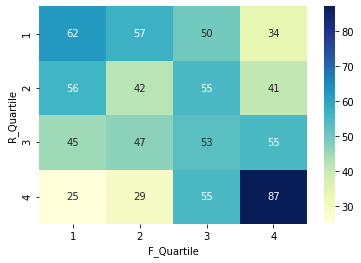

In [32]:
sns.heatmap(a, annot=True, cmap="YlGnBu")

Теперь посмотрим в какой из групп самый большой медианный доход:

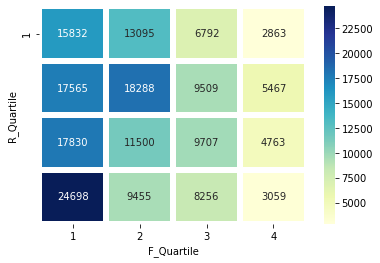

In [33]:
rfm_table = rfmSegmentation.pivot_table(
                        index='R_Quartile', 
                        columns='F_Quartile', 
                        values='monetary_value', 
                        aggfunc=np.median).applymap(int)
sns.heatmap(rfm_table, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=4.15, annot_kws={"size": 10},yticklabels=4);

# Заключение:
1. Пользователи, у которых последняя покупка была наименее давно, которые покупают наиболее часто и суммы покупок которых самые большие: @top_users
2. Группа пользователей, для которых целесообразно подобрать программу лояльности для повышения их среднего чека: @perspective_users
    